# Vorhersage des Ödometer-Versuchs mit einem neuronalen Netzwerk

**Ziel:**
Entwicklung eines neuronalen Netzes, das auf Basis gegebener Input-Parameter den Elastizitätsmodul $E_s$ im Ödometer-Versuch vorhersagt.

---

## 1. Problemformulierung

Es wird folgende Beziehung zugrunde gelegt:

$$
\dot{\sigma} = C_1\,\sigma_t\,\dot{\varepsilon} + C_2\,\sigma_t\,\left|\dot{\varepsilon}\right|
$$

Diese Gleichung beschreibt die Änderung der Spannung $\dot{\sigma}$ in Abhängigkeit von der aktuellen Spannung $\sigma_t$, der Dehnungsrate $\dot{\varepsilon}$ und den Koeffizienten $C_1, C_2$, die aus dem gewählten Modell abgeleitet sind.

---

## 2. Annahmen / Startwerte

Die Berechnung basiert auf folgenden festen Parametern:

- **Startspannung:** $\sigma_0 = -1{,}00\,\text{kPa}$
- **Porenverhältnis:** $e_0 = 1{,}00$
- **Koeffizienten:**
  - $C_c = 0{,}005$
  - $C_s = 0{,}002$
- **Dehnungsraten:**
  - Stauchungsphase: $\dot{\varepsilon}_c = -0{,}0005$
  - Dehnungsphase: $\dot{\varepsilon}_e = +0{,}0005$

---

## 3. Trainingssetup

- **Input:**
  $\sigma_t$, $\dot{\varepsilon}$
- **Output:**
  Elastizitätsmodul $E_s$

Das neuronale Netz soll aus den aktuellen Zustandsgrößen ($\sigma_t$, $\dot{\varepsilon}$) lernen, in welcher Phase (Kompression vs. Entlastung) sich der Versuch befindet, und darauf basierend $E_s$ schätzen.

---

## 4. Variablendeklaration

| Symbol              | Variable im Code     | Bedeutung |
|---------------------|----------------------|-----------|
| $\sigma_t$          | `sigma_t`            | Aktuelle Spannung zum Zeitpunkt $t$ |
| $\dot{\varepsilon}$ | `delta_epsilon`      | Dehnungsrate; negative Werte: Kompression, positive: Entlastung |
| $\dot\sigma_t$      | `delta_sigma`        | Inkrementelle Änderung der Spannung |
| $E_s$               | `e_s`                | Elastizitätsmodul (Zielgröße) |
| $e_0$               | `e_0`                | Porenverhältniszahl |

---

## 5. Hinweise zur Phase

Die Phase (Stauchung vs. Dehnung) lässt sich über das Vorzeichen von $\dot{\varepsilon}$ ablesen. Alternativ kann explizit ein Zustandsindikator (z. B. one-hot oder diskrete Labels für Belastung/Entlastung) zusätzlich als Feature mitgegeben werden, um dem Modell das Unterscheiden zu erleichtern.


# Data generation

In [1]:
from handler.handleMetaData import *

oedo_model = 1

param_spec = {
    "e0": 1.0,
    "c_c": 0.005,
    "c_s": 0.002,
    "sigma_prime_p": [-.8, -1.5],
    "sigma_max": [-900, -1100],
    "sigma_min": [-90, -110],
    "eps_delta": -0.0005,
    "eps_0": 0,
}

para_data = {
    "n_runs": 30,
    "final_samples": 500,
    "features_keys": ("sigma_0","eps_delta"),
    "target_keys": ("e_s"),
    "seed": 8,
}

tX_raw, tY_raw, info = generate_oedometer_dataset(param_spec,
                                                  n_runs=para_data["n_runs"],
                                                  final_samples=para_data["final_samples"],
                                                  oedo_model=oedo_model,
                                                  seed=para_data["seed"],
                                                  feature_keys=para_data["features_keys"],
                                                  target_key=para_data["target_keys"]
                                                  )

export_dataset_for_html(info, out_dir="oedo-viewer/viewer_data/")

schema = export_oedometer_schema(
    feature_keys=para_data["features_keys"],
    target_key=para_data["target_keys"],
    origin="generate_oedometer_dataset",
    n_runs=para_data["n_runs"],
    final_samples=para_data["final_samples"],
    seed=para_data["seed"],
    path="oedo-viewer/viewer_data/schema.json",
)

[OK] exportiert: oedo-viewer/viewer_data/samples.csv  /  oedo-viewer/viewer_data/runs.csv


In [2]:
tX, tY, meta = compose_dataset_from_files(
    samples_csv="oedo-viewer/viewer_data/samples.csv",
    additional_runs_csv="oedo-viewer/viewer_data/additional_runs.csv",  # oder runs.csv
    schema_json="oedo-viewer/viewer_data/schema.json",
    join_key="global_idx",
    join_how="left",
    # WICHTIG: runs/additional_runs haben keinen Key -> aus Zeilennummer bauen
    additional_index_from_row=True,
    additional_index_start=0,  # stell auf 1, wenn deine Samples 1-basiert zählen
    # samples hat i.d.R. die Spalte; falls nicht:
    samples_index_from_row=False,
    samples_index_start=0,
    # Auswahl (optional)
    include_additional_features=None,  # None => alle F:
    include_additional_targets=None,  # None => alle T:
    # Datenqualität
    dropna=True,
    # Normalisierung
    normalize=True,
    scaler_path="scalers.joblib",
    refit_scaler=True,
    # Export
    additional_samples_out="oedo-viewer/viewer_data/additional_samples.csv",
)
print(tX.shape)
print(tY.shape)

torch.Size([500, 2])
torch.Size([500, 1])


# Training

ep   25 | train MSE 2.1753e-01  RMSE 4.6136e-01  MAE 2.9196e-01  R² 0.7685 | val MSE 2.2995e-01  RMSE 4.7953e-01  MAE 3.0238e-01  R² 0.7733
ep   50 | train MSE 9.1799e-03  RMSE 9.5649e-02  MAE 7.1440e-02  R² 0.9898 | val MSE 9.6867e-03  RMSE 9.8421e-02  MAE 6.7070e-02  R² 0.9905
ep   75 | train MSE 1.3972e-03  RMSE 3.7035e-02  MAE 2.4730e-02  R² 0.9985 | val MSE 1.7814e-03  RMSE 4.2207e-02  MAE 2.6370e-02  R² 0.9982
ep  100 | train MSE 5.0854e-04  RMSE 2.2294e-02  MAE 1.2851e-02  R² 0.9995 | val MSE 6.7895e-04  RMSE 2.6057e-02  MAE 1.3504e-02  R² 0.9993
ep  125 | train MSE 2.5708e-04  RMSE 1.5867e-02  MAE 9.6899e-03  R² 0.9997 | val MSE 3.5778e-04  RMSE 1.8915e-02  MAE 9.9314e-03  R² 0.9996
ep  150 | train MSE 1.0581e-04  RMSE 1.0242e-02  MAE 6.4814e-03  R² 0.9999 | val MSE 1.6090e-04  RMSE 1.2685e-02  MAE 6.3288e-03  R² 0.9998
ep  175 | train MSE 5.9364e-05  RMSE 7.6787e-03  MAE 5.3077e-03  R² 0.9999 | val MSE 1.1543e-04  RMSE 1.0744e-02  MAE 5.1165e-03  R² 0.9999
ep  200 | train MSE 

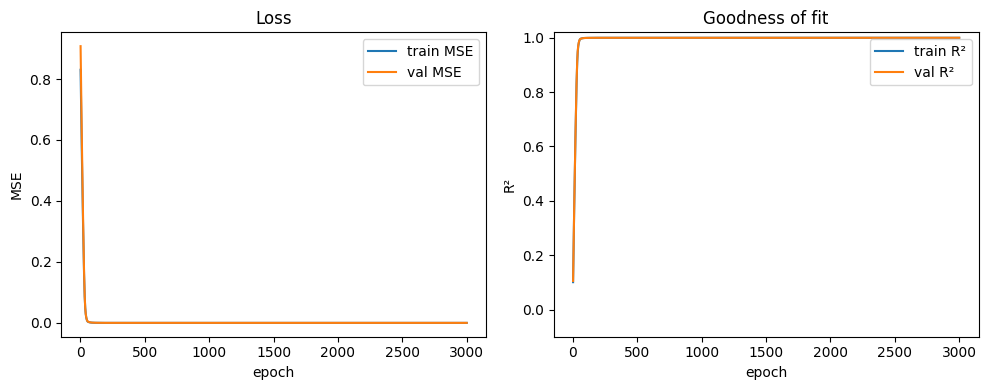

In [3]:
from nn_model.model import train_eval_save
model, splits, history_df, test_metrics_df = train_eval_save(
    X=tX, y=tY,
    feature_names=meta["feature_names"],
    additional_samples_csv=meta["additional_samples_path"],
    join_key=meta["join_key"],
    model_name="piecewise_relu",                  # swap to "piecewise_tanh", etc.
    model_kwargs=dict(width=32, depth=2),
    split_ratios=(0.70, 0.15, 0.15),              # set your own ratios
    split_seed=123,
    epochs=3000,
    out_dir="oedo-viewer/viewer_data/"                        # writes 3 CSVs here
)


# Metrics

In [4]:
import json
from pathlib import Path
from typing import Optional, Sequence, Union, Dict, Any, List

import numpy as np
import pandas as pd
import torch


@torch.no_grad()
def predict_additional_runs_to_csv(
        model: torch.nn.Module,
        samples_csv: Union[str, Path],
        additional_runs_csv: Union[str, Path],
        schema_json: Union[str, Path],
        meta: Dict[str, Any],
        *,
        out_csv: Union[str, Path] = "predictions_additional.csv",
        join_key: str = "global_idx",
        additional_index_start: int = 0,  # 0 => nullbasiert; ggf. auf 1 stellen
        include_additional_features: Optional[Sequence[str]] = None,  # None => alle F:
        include_true_T_columns: bool = True,  # echte T:-Spalten mit in die CSV schreiben (falls vorhanden)
        device: Optional[Union[str, torch.device]] = None,
) -> pd.DataFrame:
    # --- Laden ---
    samples_csv = Path(samples_csv)
    additional_runs_csv = Path(additional_runs_csv)
    schema_json = Path(schema_json)
    out_csv = Path(out_csv)

    df_s = pd.read_csv(samples_csv)
    df_a = pd.read_csv(additional_runs_csv)
    with open(schema_json, "r", encoding="utf-8") as f:
        schema = json.load(f)

    # --- join_key in additional erzeugen (autoritative Indexierung für OUT) ---
    if join_key not in df_a.columns:
        df_a = df_a.copy()
        df_a[join_key] = np.arange(additional_index_start,
                                   additional_index_start + len(df_a),
                                   dtype=int)

    # --- Trainings-Featureliste rekonstruieren ---
    X_cols_needed: List[str] = list(meta.get("feature_names", []))
    if not X_cols_needed:
        raise ValueError(
            "meta['feature_names'] fehlt – ohne diese Information können die Features nicht gebaut werden.")

    # --- Verfügbare F:/T: Spalten in additional_runs ---
    f_cols_available = [c for c in df_a.columns if isinstance(c, str) and c.startswith("F:")]
    t_cols_available = [c for c in df_a.columns if isinstance(c, str) and c.startswith("T:")]
    if include_additional_features is not None:
        missing = set(include_additional_features) - set(f_cols_available)
        if missing:
            raise KeyError(f"Gewünschte zusätzliche Feature-Spalten fehlen in additional_runs.csv: {sorted(missing)}")
        f_cols_available = list(include_additional_features)

    # --- Basis: additional_runs ist die Quelle. Nur wenn dort Features fehlen, selektiv aus samples mergen. ---
    df_m = df_a.copy()

    # Welche benötigten Features fehlen noch?
    missing_in_a = [c for c in X_cols_needed if c not in df_m.columns]
    if missing_in_a:
        # nur dann mergen, wenn samples den join_key + diese Spalten wirklich hat
        if join_key not in df_s.columns:
            raise KeyError(
                f"Folgende Modell-Features fehlen in additional_runs und können nicht aus samples gemappt werden, "
                f"weil '{join_key}' in samples.csv fehlt: {missing_in_a}"
            )
        missing_in_s = [c for c in missing_in_a if c not in df_s.columns]
        if missing_in_s:
            raise KeyError(
                f"Diese Modell-Features fehlen sowohl in additional_runs.csv als auch in samples.csv: {missing_in_s}"
            )
        df_m = pd.merge(
            df_m,
            df_s[[join_key] + missing_in_a],
            on=join_key,
            how="left"
        )

    # Final prüfen: Alle X-Spalten müssen jetzt vorhanden sein
    really_missing = [c for c in X_cols_needed if c not in df_m.columns]
    if really_missing:
        raise KeyError(
            f"Folgende für das Modell benötigte Feature-Spalten fehlen nach Zusammenführung: {really_missing}")

    # --- Numerik erzwingen (robuster gegen Strings/Whitespace) ---
    for c in X_cols_needed:
        df_m[c] = pd.to_numeric(df_m[c], errors="coerce")

    # --- Validitätsmaske: nur vollständige Zeilen in die Inferenz geben ---
    X_all = df_m[X_cols_needed].to_numpy(dtype=np.float32)
    valid_mask = ~np.any(np.isnan(X_all), axis=1)
    n, d = X_all.shape

    # Ergebniscontainer (NaN vorbelegen)
    # Zieldimension später nach erstem Forward definiert
    preds = None

    # --- Optional Normalisierung ---
    x_scaler = meta.get("x_scaler", None)
    if x_scaler is not None:
        X_all_scaled = np.empty_like(X_all)
        # nur valide Zeilen transformieren; invalide bleiben NaN
        X_all_scaled[:] = np.nan
        if valid_mask.any():
            X_all_scaled[valid_mask] = x_scaler.transform(X_all[valid_mask]).astype(np.float32)
        X_use = X_all_scaled
    else:
        X_use = X_all

    # --- Inferenz (nur für valide Zeilen) ---
    if valid_mask.any():
        X_valid = X_use[valid_mask]
        tX = torch.tensor(X_valid, dtype=torch.float32)
        model_device = next(model.parameters()).device
        if device is not None:
            tX = tX.to(device)
        else:
            tX = tX.to(model_device)

        model.eval()
        y_pred = model(tX)
        if isinstance(y_pred, torch.Tensor):
            y_pred_np = y_pred.detach().cpu().numpy()
        else:
            y_pred_np = np.asarray(y_pred, dtype=np.float32)

        # 2D-Form erzwingen
        if y_pred_np.ndim == 1:
            y_pred_np = y_pred_np.reshape(-1, 1)

        # --- ggf. Denormalisierung ---
        y_scaler = meta.get("y_scaler", None)
        if y_scaler is not None and y_pred_np.size > 0:
            y_pred_np = y_scaler.inverse_transform(y_pred_np)

        # In Gesamtcontainer eintragen
        T = y_pred_np.shape[1]
        preds = np.full((n, T), np.nan, dtype=np.float32)
        preds[valid_mask, :] = y_pred_np
    else:
        # keine validen Zeilen
        preds = np.full((n, 0), np.float32)

    # --- Zielspaltennamen bestimmen ---
    target_names = meta.get("target_names", None)
    if not target_names:
        # aus schema ableiten oder generisch
        if "target_keys" in schema and isinstance(schema["target_keys"], list) and preds.shape[1] == len(
                schema["target_keys"]):
            target_names = list(schema["target_keys"])
        elif "target_key" in schema and isinstance(schema["target_key"], str) and preds.shape[1] in (0, 1):
            target_names = [schema["target_key"]] if preds.shape[1] == 1 else []
        else:
            target_names = [f"target_{i}" for i in range(preds.shape[1])]

    # --- Output-Frame bauen ---
    out = pd.DataFrame({join_key: df_m[join_key].to_numpy()})

    if include_true_T_columns and t_cols_available:
        for col in t_cols_available:
            if col in df_m.columns:
                out[col] = df_m[col].to_numpy()

    for j, tname in enumerate(target_names):
        colname = f"pred_{tname}"
        if preds.shape[1] == 0:
            out[colname] = np.nan
        else:
            out[colname] = preds[:, j]

    out.sort_values(by=join_key, inplace=True, kind="mergesort")
    out.to_csv(out_csv, index=False)
    return out

In [5]:
# Nach dem Training:
pred_df = predict_additional_runs_to_csv(
    model=model,
    samples_csv="oedo-viewer/viewer_data/samples.csv",
    additional_runs_csv="oedo-viewer/viewer_data/additional_runs.csv",  # oder runs.csv
    schema_json="oedo-viewer/viewer_data/schema.json",
    meta=meta,  # von compose_dataset_from_files beim Training
    out_csv="oedo-viewer/viewer_data/predictions_additional.csv",
    join_key="global_idx",
    additional_index_start=0,  # 0-basiert; auf 1 setzen, wenn du 1-basiert zählen willst
    include_additional_features=None,  # optional subset der F:-Spalten
    include_true_T_columns=True,  # echte T:-Spalten zum Vergleichen mitspeichern
    device=None  # None => nimmt automatisch das Model-Device
)

print("Saved:", "oedo-viewer/viewer_data/predictions_additional.csv")

Saved: oedo-viewer/viewer_data/predictions_additional.csv


In [6]:
from handler.handleData import *

# Run mit deinen Dateien
root_dir="oedo-viewer/viewer_data/"
original_pred_path = "predictions_additional.csv"
left_path = "oedo-viewer/viewer_data/runs.csv"
right_path = "predictions_additional_processed.csv"
process_pred_3stage(
    oedo_model= 1,
    root_dir= "oedo-viewer/viewer_data/",
    preds_path= "predictions_additional.csv",
    runs_path="oedo-viewer/viewer_data/runs.csv",
    merged_path= "predictions_additional_processed.csv",
    propagated_path = "predictions_additional_processed_propagated.csv",
    split_path= "split_assignments.csv",   # in same folder
    model = model,   # PyTorch model that predicts Es from [σ0, Δε]
    x_scaler = meta.get("x_scaler", None),           # sklearn-like scaler for X (optional)
    y_scaler = meta.get("y_scaler", None),           # sklearn-like scaler for y (optional, inverse_transform)
    device = None,
    propagated_recursive_path = "predictions_additional_processed_propagated_recursive.csv",
)
merged_df = merge_csv_simple(root_dir + left_path,root_dir + right_path, right_start_col=0)
merged_csv_path = Path(root_dir + "runs_final.csv")

merged_df.to_csv(merged_csv_path, index=False)